In [17]:
library(ggplot2)
library(ggpubr)
library(ggsci)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
out_fold  <- 'priler_project/Figure_CASTom-iGEx_paper/CAD_part2/'
fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/CAD_HARD_clustering/clLiver_'

# load clustering result
clust_file <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/tscore_zscaled_clusterCases_PGmethod_HKmetric.RData'
res_cl <- get(load(clust_file))

# load features association
tscore_featRel_tot_file <- sprintf('%stscoreOriginal_tscoreClusterCases_featAssociation.txt', fold)
tscore_featRel_info_file <- sprintf('%stscoreOriginal_tscoreClusterCases_infoGenes.txt', fold)
pathGO_featRel_tot_file <- sprintf('%spath_GOOriginal_tscoreClusterCases_featAssociation.txt', fold)
pathR_featRel_info_file <- sprintf('%spath_ReactomeOriginal_tscoreClusterCases_infoGenes.txt', fold)
pathGO_featRel_info_file <- sprintf('%spath_GOOriginal_tscoreClusterCases_infoGenes.txt', fold)
pathR_featRel_tot_file <- sprintf('%spath_ReactomeOriginal_tscoreClusterCases_featAssociation.txt', fold)


tscore_feat <- read.delim(tscore_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
tscore_info <- read.delim(tscore_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
tscore_feat_sign <- tscore_feat[tscore_feat$pval_corr <= 0.05, ]
pathR_feat <- read.delim(pathR_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_feat <- read.delim(pathGO_featRel_tot_file, h=T, stringsAsFactors = F, sep = '\t')
pathR_info <- read.delim(pathR_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')
pathGO_info <- read.delim(pathGO_featRel_info_file, h=T, stringsAsFactors = F, sep = '\t')

# load treatment matrix
treat_file <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/CAD/Covariates/UKBB/CAD_HARD_clustering/covariateMatrix_CADHARD_All_phenoAssoc_withMedication.txt'
treatInfo_file <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/CAD/Covariates/UKBB/CAD_HARD_clustering/phenotypeDescription_covariateMatrix_withMedication.txt'
treatDat <- fread(treat_file, h=T, stringsAsFactors = F, data.table = F)
treatInfo <- fread(treatInfo_file, h=T, stringsAsFactors = F, data.table = F)

# load phenotype matrix
pheno_file <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/CAD/Covariates/UKBB/CAD_HARD_clustering/phenotypeMatrix_CADHARD_All_phenoAssoc_withMedication.txt'
phenoInfo_file <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/CAD/Covariates/UKBB/CAD_HARD_clustering/phenotypeDescription_withMedication.txt'
phenoDat <- fread(pheno_file, h=T, stringsAsFactors = F, data.table = F)
phenoInfo <- fread(phenoInfo_file, h=T, stringsAsFactors = F, data.table = F)

# load analysis results
tissue_name <- 'Liver'
treatmentResponsePairwiseFile <- sprintf('CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/withMedication_tscore_zscaled_clusterCases_TreatResponse_pairwise.txt', tissue_name)
res_treat <- fread(treatmentResponsePairwiseFile, h=T, stringsAsFactors = F, data.table = F)

# load original data
phenoOriginal_file <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/CAD/Covariates/UKBB/ukb40052_project25214_filtered_britishWhiteUnrelated_pheno.tab'
phenoOriginal <- fread(phenoOriginal_file, h=T, stringsAsFactors = F, data.table = F)
# convert id
id_conv <- fread('/psycl/g/mpsukb/UKBB_hrc_imputation/oxford/samples_unrelated_ukb25214_ukb34217', h=T, stringsAsFactors = F)
phenoOriginal$new_userId <- id_conv$ukb34217[match(phenoOriginal$userId, id_conv$ukb25214)]

[1] "C"

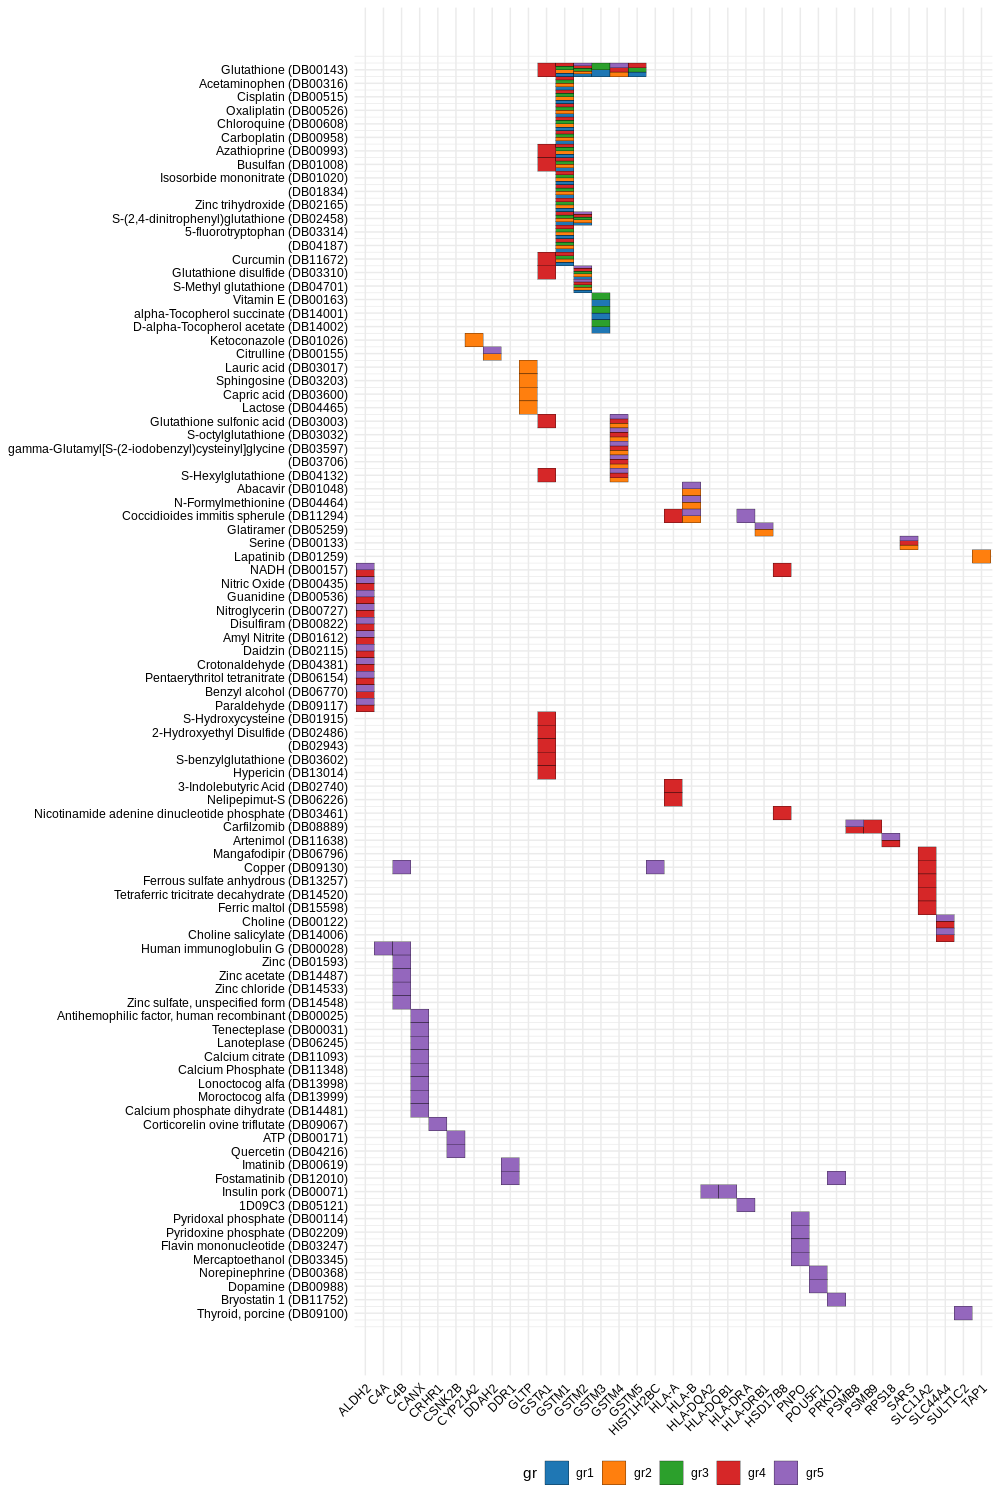

In [13]:
#########################################
###### target drugs genes/pathways ######
#########################################
options(repr.plot.width = 10, repr.plot.height = 15, repr.plot.res = 100)

#library(drugbankR)
drugbank_genes <- 'refData/drugBank/All_geneTargets_enzymes.txt'

db_genes <- fread(drugbank_genes, h=T, stringsAsFactors = F, data.table = F)
#df <- queryDB(type = "getAll", db_path=sprintf("%sdrugbank_5.1.7.db", 'refData/drugBank/'))
#id_CAD = unique(c(grep("artery", df$`mechanism-of-action`), grep("artery", df$indication)))
#name_CAD <- unique(df[id_CAD, "drugbank-id"])
gr <- unique(tscore_feat_sign$comp)
tscore_feat_sign$feat_tissue <- paste(tscore_feat_sign$feat, tscore_feat_sign$tissue, sep = '_')

genes_cl <- list()
db_genes_cl <- list()
for(i in 1:length(gr)){
    feat_tmp <- tscore_feat_sign[tscore_feat_sign$comp == gr[i], ]
    info_tmp <- tscore_info[match(feat_tmp$feat_tissue, paste(tscore_info$external_gene_name, tscore_info$tissue, sep = '_')), ]
    feat_tmp$Zstat <- info_tmp$Zstat

    # remove significant genes for SCZ that have a opposite effect (protective of SCZ)
    id_genes <- feat_tmp$feat[abs(feat_tmp$Zstat) > 1 & sign(feat_tmp$Zstat*feat_tmp$estimates) == -1]

    if(length(id_genes)>0){
        feat_tmp <- feat_tmp[!feat_tmp$feat %in% id_genes,]
    }
    genes_cl[[i]] <- unique(feat_tmp$feat)
    db_genes_cl[[i]] <- db_genes[db_genes$gene %in% genes_cl[[i]],]
    db_genes_cl[[i]] <- db_genes_cl[[i]][order(db_genes_cl[[i]]$gene), ]
    db_genes_cl[[i]]$gr <- strsplit(gr[i], split = '_vs_all')[[1]]
}
db_genes_cl <- do.call(rbind, db_genes_cl)

# plot 
#db_genes_cl[db_genes_cl$id %in% name_CAD,]
id_long <- nchar(db_genes_cl$drug) > 50
db_genes_cl$new_name[!id_long] <- paste0(db_genes_cl$drug[!id_long], ' (', db_genes_cl$id[!id_long], ')')
db_genes_cl$new_name[id_long] <- paste0('(', db_genes_cl$id[id_long], ')')


db_genes_cl$new_name <- factor(db_genes_cl$new_name, levels = rev(unique(db_genes_cl$new_name)))
db_genes_cl$gr <- factor(db_genes_cl$gr)
# remove repetiton due to type
db_genes_cl$tot_id <- paste(db_genes_cl$gene, db_genes_cl$id, db_genes_cl$gr,'_')
db_genes_cl <- db_genes_cl[!duplicated(db_genes_cl$tot_id),] 

tmp <- data.table(db_genes_cl)
tmp[, shift:=(1:(.N))/.N - 1/(2 * .N) - 1/2, by=list(gene, new_name)]
tmp[, height:=1/.N, by=list(gene, new_name)]

pl <- ggplot(tmp,  aes(x=gene, y = as.numeric(new_name) + shift ,fill = gr, height=height)) + 
            geom_tile(color = 'black', size = 0.1) + 
            theme_minimal()+
            theme(axis.title = element_blank(), axis.text = element_text(color = 'black'), 
                 axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'bottom')+
            scale_y_continuous(breaks=sort(unique(as.numeric(tmp$new_name))), 
                               labels = levels(tmp$new_name))+
            coord_cartesian(ylim = c(1, max(as.numeric(tmp$new_name))))+
            scale_fill_d3()
pl

ggsave(filename = sprintf('%sclusterLiver_Genes_CAD_DrugBank_interactions.png', out_fold), plot = pl, width = 10, height = 15, dpi = 500)
ggsave(filename = sprintf('%sclusterLiver_Genes_CAD_DrugBank_interactions.pdf', out_fold), plot = pl, width = 10, height = 15, compress = F)


In [20]:
# Pathway
tmp1 <- pathR_info[, c('path', 'ngenes_tscore', 'genes_id', 'tissue', 'Zstat')]
tmp1$type_path <- 'Reactome'
tmp2 <- pathGO_info[, c('path', 'ngenes_tscore', 'genes_id', 'tissue', 'Zstat')]
tmp2$type_path <- 'GO'
path_info_drug <- rbind(tmp1, tmp2)
path_info_drug$id <- paste(path_info_drug$path,  path_info_drug$tissue, sep = '_')
id <- pathR_feat$pval_corr <= 0.05
id_keepR <- which(path_info_drug$id %in% paste(pathR_feat$feat[id], pathR_feat$tissue[id], sep = '_') & path_info_drug$type+path == 'Reactome')
id <- pathGO_feat$pval_corr <= 0.05
id_keepR <- which(path_info_drug$id %in% paste(pathR_feat$feat[id], pathR_feat$tissue[id], sep = '_') & path_info_drug$type+path == 'Reactome')


path_info_drug$drugBank_ann <- NA
path_info_drug$drugBank_n <- NA
path_info_drug$drugBank_id <- NA
path_info_drug$drugBank_gene <- NA
#path_info_drug$drugBank_usedForSCZ <- NA

for(i in 1:nrow(path_info_drug)){
    path_name = path_ann_drug$path[i]
    genes_path <- strsplit(path_ann_drug$genes_path[path_ann_drug$path == path_name], split = ',')[[1]]
    drug_ann <- db_genes[db_genes$gene %in% genes_path,,drop = F]
    path_info_drug$drugBank_ann[i] <- paste0(unique(drug_ann$drug), collapse = '-and-')
    path_info_drug$drugBank_id[i] <- paste0(unique(drug_ann$id), collapse = '-and-')
    path_info_drug$drugBank_n[i] <- nrow(drug_ann)
    path_info_drug$drugBank_gene[i] <- paste0(unique(drug_ann$gene), collapse = '-and-')
    #path_ann_drug$drugBank_usedForSCZ[i] <- paste0(unique(drug_ann$drug[drug_ann$id %in% name_SCZ]), collapse = '-and-')
}

# save table
write.table(path_ann_drug, file = sprintf('%sPathScore_SCZ_annotated_drugBank.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

# reduce category
path_ann_drug_red <- path_ann_drug[path_ann_drug$type_path %in% c('Reactome', 'GO') & path_ann_drug$class_pathway == "pathway P < genes P & genes FDR > 0.05", ]
path_ann_drug_red <- path_ann_drug_red[(path_ann_drug_red$path %in% pathGO$path[pathGO$path_ont %in% c('BP', 'MF')] & path_ann_drug_red$type_path %in% 'GO') | path_ann_drug_red$type_path %in% 'Reactome',]
# save table
write.table(path_ann_drug_red, file = sprintf('%sPathScore_SCZ_annotated_drugBank_notSignGenes_GOandReactome.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)

,path,ngenes_tscore,genes_id,tissue,Zstat,type_path
,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>
1,2-LTR circle formation,2,"BANF1,XRCC5",Adipose_Visceral_Omentum,0.6306896,Reactome
2,Abacavir metabolism,4,"ADAL,ADH1A,GUK1,NT5C2",Adipose_Subcutaneous,0.2587483,Reactome
3,Abacavir metabolism,4,"ADAL,ADH1A,GUK1,NT5C2",Adipose_Visceral_Omentum,0.4515747,Reactome
4,Abacavir metabolism,3,"ADAL,ADH1A,NT5C2",Artery_Aorta,-0.2512475,Reactome
5,Abacavir metabolism,2,"ADAL,ADH1A",Colon_Sigmoid,-1.0022916,Reactome
6,Abacavir metabolism,2,"ADAL,ADH1A",Heart_Atrial_Appendage,-0.3478690,Reactome


ERROR: Error in path_ann_drug$drugBank_ann <- NA: object 'path_ann_drug' not found


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 330 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 330 rows containing missing values (geom_point).”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


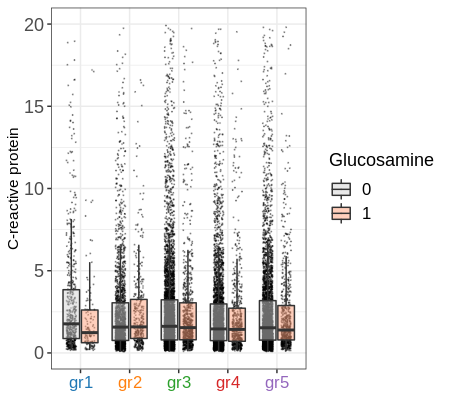

Warning message:
“Removed 330 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 330 rows containing missing values (geom_point).”
Warning message:
“Removed 330 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 330 rows containing missing values (geom_point).”


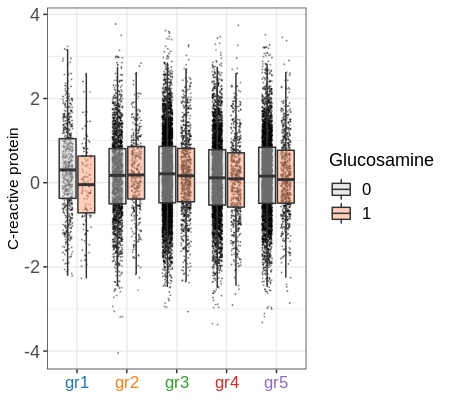

In [9]:
options(repr.plot.width = 4.5, repr.plot.height = 4, repr.plot.res = 100)

# plot specific treatment response
pheno_name <- 'C-reactive protein'
#pheno_name <- 'Platelet crit'
treat_name <- 'Glucosamine'
#a = res_treat[res_treat$pheno_Field %in% pheno_name,]
#a = res_treat
#a[order(a$pvalue_diff)[1:10],]

pheno_id <- phenoInfo$pheno_id[phenoInfo$Field == pheno_name]
treat_id <- treatInfo$pheno_id[treatInfo$Coding_meaning == treat_name]
cl <- res_cl$cl_best

df <- data.frame(id = cl$id, gr = cl$gr, 
                 pheno = phenoDat[match(cl$id, phenoDat$Individual_ID), pheno_id], 
                 pheno_or = phenoOriginal[match(cl$id, paste0('X',phenoOriginal$new_userId)), paste0('x', pheno_id, '_0_0')],
                 treat = treatDat[match(cl$id, treatDat$Individual_ID), paste0('p', treat_id)])

df$gr <- paste0('gr',df$gr)
df$gr <- factor(df$gr, levels = paste0('gr', sort(unique(cl$gr))))
df$treat <- factor(df$treat)
# remove NA values:
df <- df[!is.na(df$treat) & !is.na(df$pheno),]


gr_color <- pal_d3(palette = 'category20')(length(unique(df$gr)))

pl_box_original <-  ggplot(df, aes(x = gr, y = pheno_or, fill = treat))+
  geom_point(size = 0.1, alpha = 0.3, position = position_jitterdodge())+  
  geom_boxplot(outlier.shape = NA, alpha = 0.5)+
  theme_bw()+ 
  ylim(0,20)+
  ylab(pheno_name)+
  theme(legend.position = 'right', legend.title = element_text(size = 13), legend.text = element_text(size = 12), 
        plot.title = element_text(size=12), axis.title.x = element_blank(),
        axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, colour = gr_color), axis.text.y = element_text(size = 13))+
 scale_fill_manual(name = treat_name,values=c('lightgrey', 'lightsalmon1'))

pl_box_original

pl_box <-  ggplot(df, aes(x = gr, y = pheno, fill = treat))+
  geom_point(size = 0.1, alpha = 0.3, position = position_jitterdodge())+  
  geom_boxplot(outlier.shape = NA, alpha = 0.5)+
  theme_bw()+ 
  ylab(pheno_name)+
  theme(legend.position = 'right', legend.title = element_text(size = 13), legend.text = element_text(size = 12), 
        plot.title = element_text(size=12), axis.title.x = element_blank(),
        axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, colour = gr_color), axis.text.y = element_text(size = 13))+
 scale_fill_manual(name = treat_name,values=c('lightgrey', 'lightsalmon1'))

pl_box

# save
ggsave(filename = sprintf('%soriginalPheno_%s_treat%s.png', out_fold, pheno_id, treat_id), plot = pl_box_original, width = 4.5, height = 4, dpi = 300)
ggsave(filename = sprintf('%soriginalPheno_%s_treat%s.pdf', out_fold, pheno_id, treat_id), plot = pl_box_original, width = 4.5, height = 4)

ggsave(filename = sprintf('%sPheno_%s_treat%s.png', out_fold, pheno_id, treat_id), plot = pl_box, width = 4.5, height = 4, dpi = 300)
ggsave(filename = sprintf('%sPheno_%s_treat%s.pdf', out_fold, pheno_id, treat_id), plot = pl_box, width = 4.5, height = 4)


,treat_id,z_diff,pvalue_diff,gr1_beta,gr1_se_beta,gr1_ORorBeta,gr1_CI_low,gr1_CI_up,gr1_pvalue,gr2_beta,⋯,gr2_pvalue,comp,treat_Field,treat_meaning,pheno_id,pheno_Field,pheno_meaning,pheno_type,pheno_class,pvalue_corr_diff
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<lgl>,<chr>,<chr>,<dbl>
9414,p6179_5,3.991547,6.564363e-05,-0.1585894152,0.09259447,-0.1585894152,-0.34007124,0.02289241,8.683331e-02,-0.6380429,⋯,9.292134e-17,gr4_vs_gr3,Mineral and other dietary supplements,Iron,30020,Haemoglobin concentration,NA,CONTINUOUS,Blood_count,0.005448421
12236,p6179_5,-3.863100,1.119572e-04,-0.6434367306,0.08472516,-0.6434367306,-0.80949499,-0.47737848,3.709664e-14,-0.1585894,⋯,8.683331e-02,gr5_vs_gr4,Mineral and other dietary supplements,Iron,30020,Haemoglobin concentration,NA,CONTINUOUS,Blood_count,0.009292449
3885,p6155_6,-3.764967,1.665713e-04,-0.3491941016,0.08342210,-0.3491941016,-0.51269842,-0.18568978,2.893691e-05,0.4909356,⋯,1.795366e-02,gr5_vs_gr1,Vitamin and mineral supplements,Folic acid or Folate (Vit B9),30750,Glycated haemoglobin (HbA1c),NA,CONTINUOUS,Blood_biochemistry,0.011826564
6156,p6154_2,3.757570,1.715711e-04,0.0008096496,0.03637841,0.0008096496,-0.07049073,0.07211003,9.822442e-01,-0.2478962,⋯,7.691646e-06,gr3_vs_gr2,"Medication for pain relief, constipation, heartburn",Ibuprofen (e.g. Nurofen),47,Hand grip strength (right),NA,CONTINUOUS,Hand_grip_strength,0.013554120
5274,p6155_3,3.712501,2.052213e-04,0.0473836788,0.04966049,0.0473836788,-0.04994909,0.14471644,3.400476e-01,-0.2945598,⋯,1.500541e-04,gr3_vs_gr2,Vitamin and mineral supplements,Vitamin C,30880,Urate,NA,CONTINUOUS,Blood_biochemistry,0.016212485
9561,p6155_4,-3.634808,2.781872e-04,-0.2485379505,0.10884692,-0.2485379505,-0.46187399,-0.03520191,2.245650e-02,0.2701428,⋯,3.430326e-03,gr4_vs_gr3,Vitamin and mineral supplements,Vitamin D,30110,Platelet distribution width,NA,CONTINUOUS,Blood_count,0.023089540
5443,p6154_3,-3.625688,2.881934e-04,0.0445489085,0.03083040,0.0445489085,-0.01587756,0.10497537,1.485216e-01,0.2492257,⋯,1.484977e-07,gr3_vs_gr2,"Medication for pain relief, constipation, heartburn",Paracetamol,30080,Platelet count,NA,CONTINUOUS,Blood_count,0.022767281
197,p6179_2,3.577390,3.470422e-04,0.0462089681,0.05527342,0.0462089681,-0.06212494,0.15454288,4.032371e-01,-0.3609507,⋯,3.061988e-04,gr2_vs_gr1,Mineral and other dietary supplements,Glucosamine,30710,C-reactive protein,NA,CONTINUOUS,Blood_biochemistry,0.024639998
5532,p6155_4,-3.548152,3.879440e-04,-0.0434332227,0.09081101,-0.0434332227,-0.22141953,0.13455308,6.324681e-01,0.5668006,⋯,1.069910e-04,gr3_vs_gr2,Vitamin and mineral supplements,Vitamin D,30130,Monocyte count,NA,CONTINUOUS,Blood_count,0.030647572


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Removed 330 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 330 rows containing missing values (geom_point).”
Warning message:
“Removed 330 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 330 rows containing missing values (geom_point).”


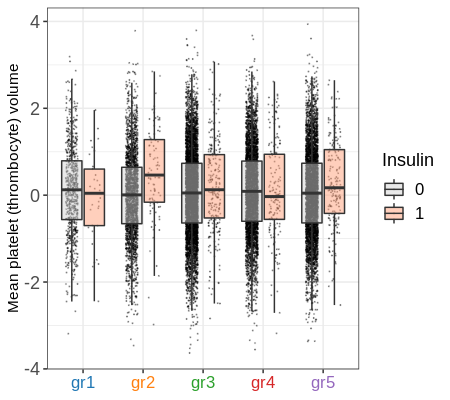

In [10]:
options(repr.plot.width = 4.5, repr.plot.height = 4, repr.plot.res = 100)

# plot specific treatment response
#pheno_name <- 'Platelet distribution width'
treat_name <- 'Insulin'
pheno_name <- 'Mean platelet (thrombocyte) volume'
#a = res_treat[res_treat$pheno_Field %in% pheno_name,]
a = res_treat
a[order(a$pvalue_diff)[1:10],]

pheno_id <- phenoInfo$pheno_id[phenoInfo$Field == pheno_name]
#treat_id <- treatInfo$pheno_id[treatInfo$Coding_meaning == treat_name]
treat_id <- '6153_6177_3'
cl <- res_cl$cl_best

df <- data.frame(id = cl$id, gr = cl$gr, 
                 pheno = phenoDat[match(cl$id, phenoDat$Individual_ID), pheno_id], 
                 #pheno_or = phenoOriginal[match(cl$id, paste0('X',phenoOriginal$new_userId)), paste0('x', pheno_id, '_0_0')],
                 treat = treatDat[match(cl$id, treatDat$Individual_ID), paste0('p', treat_id)])

df$gr <- paste0('gr',df$gr)
df$gr <- factor(df$gr, levels = paste0('gr', sort(unique(cl$gr))))
df$treat <- factor(df$treat)
# remove NA values:
df <- df[!is.na(df$treat) & !is.na(df$pheno),]


gr_color <- pal_d3(palette = 'category20')(length(unique(df$gr)))

#pl_box_original <-  ggplot(df, aes(x = gr, y = pheno_or, fill = treat))+
#  geom_point(size = 0.1, alpha = 0.3, position = position_jitterdodge())+  
#  geom_boxplot(outlier.shape = NA, alpha = 0.5)+
#  theme_bw()+ 
#  ylim(15,70)+
#  ylab(pheno_name)+
# theme(legend.position = 'right', legend.title = element_text(size = 13), legend.text = element_text(size = 12), #        plot.title = element_text(size=12), axis.title.x = element_blank(),
#        axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, colour = gr_color), axis.text.y = element_text(size = 13))+
# scale_fill_manual(name = treat_name,values=c('lightgrey', 'lightsalmon1'))

#pl_box_original

pl_box <-  ggplot(df, aes(x = gr, y = pheno, fill = treat))+
  geom_point(size = 0.1, alpha = 0.3, position = position_jitterdodge())+  
  geom_boxplot(outlier.shape = NA, alpha = 0.5)+
  theme_bw()+ 
  ylab(pheno_name)+
  theme(legend.position = 'right', legend.title = element_text(size = 13), legend.text = element_text(size = 12), 
        plot.title = element_text(size=12), axis.title.x = element_blank(),
        axis.text.x = element_text(size = 12, angle = 0, hjust = 0.5, colour = gr_color), axis.text.y = element_text(size = 13))+
 scale_fill_manual(name = treat_name,values=c('lightgrey', 'lightsalmon1'))

pl_box

# save
ggsave(filename = sprintf('%soriginalPheno_%s_treat%s.png', out_fold, pheno_id, treat_id), plot = pl_box_original, width = 4.5, height = 4, dpi = 300)
ggsave(filename = sprintf('%soriginalPheno_%s_treat%s.pdf', out_fold, pheno_id, treat_id), plot = pl_box_original, width = 4.5, height = 4)

ggsave(filename = sprintf('%sPheno_%s_treat%s.png', out_fold, pheno_id, treat_id), plot = pl_box, width = 4.5, height = 4, dpi = 300)
ggsave(filename = sprintf('%sPheno_%s_treat%s.pdf', out_fold, pheno_id, treat_id), plot = pl_box, width = 4.5, height = 4)
